# Overscan, Trim, Bias, Dark and Flat calibration

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
from glob import glob
import matplotlib
#matplotlib.use('nbagg')
import astropy.stats

In [3]:
# A little script to get information on all the fits files
def ccdlist(input=None):
    if input is None: input='*.fits'
    files = glob(input)
    nfiles = len(files)
    dt = np.dtype([('file',np.str,100),('naxis1',int),('naxis2',int),
                      ('imagetyp',np.str,100),('exptime',float),('filter',np.str,100)])
    cat = np.zeros(nfiles,dtype=dt)
    for i,f in enumerate(files):
        base = os.path.basename(f)
        base = base.split('.')[0]
        h = fits.getheader(f)
        cat['file'][i] = f
        cat['naxis1'][i] = h.get('naxis1')
        cat['naxis2'][i] = h.get('naxis2')
        cat['imagetyp'][i] = h.get('imagetyp')
        cat['exptime'][i] = h.get('exptime')
        cat['filter'][i] = h.get('filter')
        print(base+'  '+str(cat['naxis1'][i])+'  '+str(cat['naxis2'][i])+'  '+cat['imagetyp'][i]+'  '+str(cat['exptime'][i])+'  '+cat['filter'][i])
    return cat

In [4]:
def ccdlistold(input=None):
    if input is None: input='*.fits'
    files = glob(input)
    nfiles = len(files)
    dt = np.dtype([('file',np.str,100),('naxis1',int),('naxis2',int),
                      ('obstype',np.str,100),('exposure',float),('filter',np.str,100)])
    cat = np.zeros(nfiles,dtype=dt)
    for i,f in enumerate(files):
        base = os.path.basename(f)
        base = base.split('.')[0]
        h = fits.getheader(f)
        print(base+'  '+str(h['naxis1'])+'  '+str(h['naxis2'])+'  '+h['obstype']+'  '+str(h['exptime'])+'  '+h['filter'])
        cat['file'][i] = f
        cat['naxis1'][i] = h['naxis1']
        cat['naxis2'][i] = h['naxis2']
        cat['obstype'][i] = h['obstype']
        cat['exposure'][i] = h['exptime']
        cat['filter'][i] = h['filter']
    return cat

In [5]:
out=ccdlist('data/calibration_data/*.fit')
# out=ccdlistold('data/decambiasdark/*.fits')

<ipython-input-3-ac16341c24ce>:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dt = np.dtype([('file',np.str,100),('naxis1',int),('naxis2',int),
<ipython-input-3-ac16341c24ce>:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('imagetyp',np.str,100),('exptime',float),('filter',np.str,100)])


Bias-0001  3468  2728  Bias Frame  0.001000000047497  None
Bias-0002  3468  2728  Bias Frame  0.001000000047497  None
Bias-0003  3468  2728  Bias Frame  0.001000000047497  None
Bias-0004  3468  2728  Bias Frame  0.001000000047497  None
Bias-0005  3468  2728  Bias Frame  0.001000000047497  None
Bias-0006  3468  2728  Bias Frame  0.001000000047497  None
Bias-0007  3468  2728  Bias Frame  0.001000000047497  None
Bias-0008  3468  2728  Bias Frame  0.001000000047497  None
Bias-0009  3468  2728  Bias Frame  0.001000000047497  None
Bias-0010  3468  2728  Bias Frame  0.001000000047497  None
DoubleCluster-0003B  3468  2728  Light Frame  120.0  Blue
DoubleCluster-0003R  3468  2728  Light Frame  120.0  Red
DoubleCluster-0023B  3468  2728  Light Frame  30.0  Green
master_dark  3388  2712  Dark Frame  60.0  None
master_flat  3388  2712  Light Frame  30.0  None


## 1. Overscan

Load the data and header (using fits.getdata) for the first bias frame.  Plot up the image.

In [6]:
# im, head = fits.getdata('data/calibration_data/Bias-0001.fit',0,header=True)
im, head = fits.getdata('data/calibration_data/DoubleCluster-0003B.fit',0,header=True)

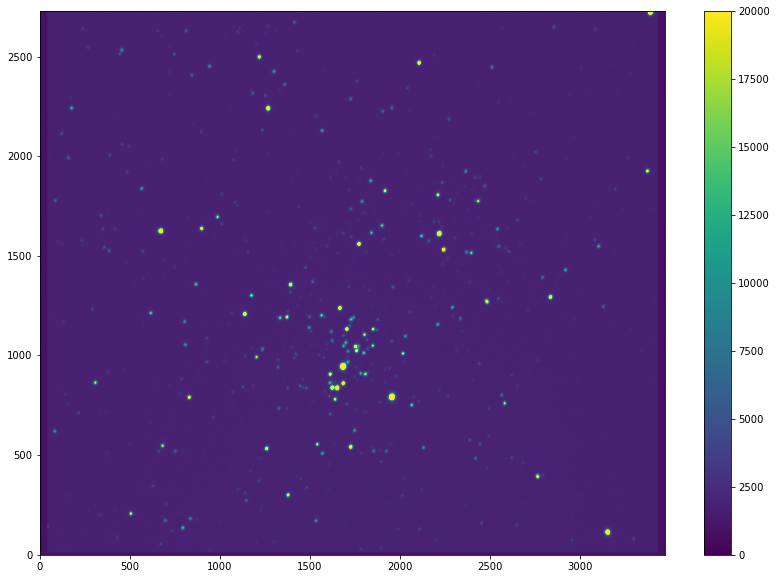

In [7]:
# plt.imshow(im,vmin=0,vmax=2000,aspect='auto',origin='lower')
# plt.colorbar()
plt.figure(figsize=(14,10))
plt.imshow(im,aspect='auto',vmax=20000,origin='lower')
plt.colorbar()
plt.show()

In [7]:
head

SIMPLE  =                    T /                                                
BITPIX  =                   16 /  8 unsigned int, 16 & 32 int, -32 & -64 real   
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 3468 /fastest changing axis                           
NAXIS2  =                 2728 /next to fastest changing axis                   
EXTEND  =                    T /   Extensions may be present                    
BSCALE  =                    1 /  physical = BZERO + BSCALE*array_value         
BZERO   =                32768 /  physical = BZERO + BSCALE*array_value         
DATE-OBS= '2020-02-22T04:08:19.00' /YYYY-MM-DDThh:mm:ss observation start, UT   
EXPTIME =   120.00000000000000 /Exposure time in seconds                        
EXPOSURE=   120.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.2000007629394

Figure out where the overscan regions are.

In [8]:
# BIASSECA
# BIASSECB
# 3229:3467 right
# 0:40 left
# 0:14 bot
over_right = im[:,3229:-3]
over_left = im[:,0:40]
over_bot = im[0:14,:-3]

Calculate the median overscan value using the largest overscan regions.

In [9]:
over = np.append(over_right.flatten(), over_left.flatten())
over = np.append(over.flatten(), over_bot.flatten())
over_med = np.median(over)
over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]

# over_right_med = np.median(over_right)
# over_left_med = np.median(over_left)|
# over_bot_med = np.median(over_bot)

Figure out where the data section is.

In [10]:
im_data = im[14:,41:3229]
im_data

array([[1897, 1845, 1822, ..., 1977, 1905, 1803],
       [1983, 1850, 1803, ..., 1903, 1867, 1814],
       [1712, 1720, 1916, ..., 1956, 1925, 1839],
       ...,
       [1815, 1914, 1792, ..., 1787, 1872, 1755],
       [ 962, 1005,  981, ...,  968,  968,  962],
       [ 982,  928,  958, ..., 1007,  965,  990]], dtype=uint16)

Subtract the overscan value from the data section.

In [11]:
im_data = im_data - over_sig_mean
im_data

array([[ 343.47776927,  291.47776927,  268.47776927, ...,  423.47776927,
         351.47776927,  249.47776927],
       [ 429.47776927,  296.47776927,  249.47776927, ...,  349.47776927,
         313.47776927,  260.47776927],
       [ 158.47776927,  166.47776927,  362.47776927, ...,  402.47776927,
         371.47776927,  285.47776927],
       ...,
       [ 261.47776927,  360.47776927,  238.47776927, ...,  233.47776927,
         318.47776927,  201.47776927],
       [-591.52223073, -548.52223073, -572.52223073, ..., -585.52223073,
        -585.52223073, -591.52223073],
       [-571.52223073, -625.52223073, -595.52223073, ..., -546.52223073,
        -588.52223073, -563.52223073]])

Write a small function called ``overscan()`` that performs all of these tasks given the image and header.

In [12]:
def overscan(im1):
    over_right = im1[:,3229:-3]
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]
    im_data = im1[14:,41:3229]
    im_data = im_data - over_sig_mean
    return im_data
overscan(im)

array([[ 343.47776927,  291.47776927,  268.47776927, ...,  423.47776927,
         351.47776927,  249.47776927],
       [ 429.47776927,  296.47776927,  249.47776927, ...,  349.47776927,
         313.47776927,  260.47776927],
       [ 158.47776927,  166.47776927,  362.47776927, ...,  402.47776927,
         371.47776927,  285.47776927],
       ...,
       [ 261.47776927,  360.47776927,  238.47776927, ...,  233.47776927,
         318.47776927,  201.47776927],
       [-591.52223073, -548.52223073, -572.52223073, ..., -585.52223073,
        -585.52223073, -591.52223073],
       [-571.52223073, -625.52223073, -595.52223073, ..., -546.52223073,
        -588.52223073, -563.52223073]])

Make line plot along the overscan region.  Do the values look constant with some noise?

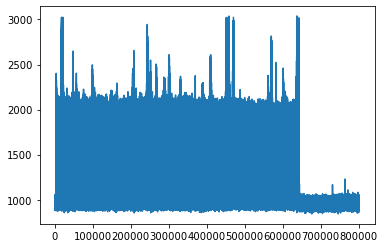

In [13]:
clipped = astropy.stats.sigma_clip(over)
xlin = np.linspace(0, len(clipped), len(clipped))
plt.plot(xlin, clipped)
plt.show()

Now modify your function to fit a line to the overscan data instead of just using the median using ``np.polyfit()``.  Use ``np.poly1d()`` to get the linear fit and ``np.repeat()`` and ``reshape()`` to produce the linear model for the entire image.

In [14]:
def overscan_lin(im1):
    over_right = im1[:,3229:-3]
    over_left = im1[:,0:40]
    over_bot = im1[0:14,:-3]
    
    im_data = im1[14:,41:3229]
    
    con = np.concatenate([over_right, over_left],axis=1)
    means = astropy.stats.sigma_clipped_stats(con[:-14], axis=1)[0]
    p = np.polyfit(np.arange(len(means)), means, 1)
    sub = np.arange(len(means))*p[0] - p[1]
    sub = np.repeat(sub,im_data.shape[1])
    sub = sub.reshape(im_data.shape)
    im_data_new = im_data+sub
    return im_data_new


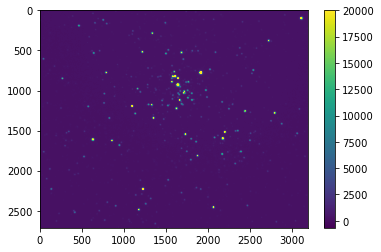

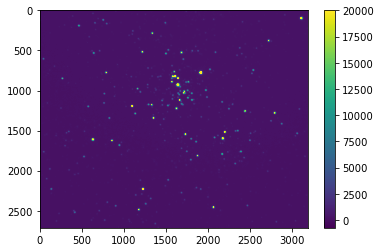

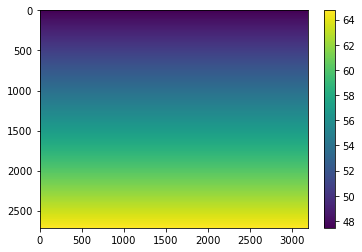

In [22]:

plt.imshow(overscan(im),aspect='auto',vmax=20000)
plt.colorbar()
plt.show()
plt.imshow(overscan_lin(im),aspect='auto',vmax=20000)
plt.colorbar()
plt.show()
plt.imshow(overscan(im)-overscan_lin(im),aspect='auto')
plt.colorbar()
plt.show()

## 2. Trim

Figure out which section of the image you should remove and which you should keep.

Trim the image.  Verify my showing the image that it looks like what you expected.

Create a new function called ``overscantrim()`` to overscan correct and trim the image.

In [16]:
#already in overscan

## 3. Bias

Use the ccdlist() function to get information about all of the exposures.  Use ``np.where()`` to get the names of just the bias exposures using header information in the output catalog.

In [34]:
lis = ccdlist('data/calibration_data/*.fit')
print(f"lis: \n {lis}")
np.where([lis[2] == "Bias Frame", lis])

Bias-0001  3468  2728  Bias Frame  0.001000000047497  None
Bias-0002  3468  2728  Bias Frame  0.001000000047497  None
Bias-0003  3468  2728  Bias Frame  0.001000000047497  None
Bias-0004  3468  2728  Bias Frame  0.001000000047497  None
Bias-0005  3468  2728  Bias Frame  0.001000000047497  None
Bias-0006  3468  2728  Bias Frame  0.001000000047497  None
Bias-0007  3468  2728  Bias Frame  0.001000000047497  None
Bias-0008  3468  2728  Bias Frame  0.001000000047497  None
Bias-0009  3468  2728  Bias Frame  0.001000000047497  None
Bias-0010  3468  2728  Bias Frame  0.001000000047497  None
DoubleCluster-0003B  3468  2728  Light Frame  120.0  Blue
DoubleCluster-0003R  3468  2728  Light Frame  120.0  Red
DoubleCluster-0023B  3468  2728  Light Frame  30.0  Green
master_dark  3388  2712  Dark Frame  60.0  None
master_flat  3388  2712  Light Frame  30.0  None
lis: 
 [('data/calibration_data\\Bias-0001.fit', 3468, 2728, 'Bias Frame', 1.00000005e-03, 'None')
 ('data/calibration_data\\Bias-0002.fit',

<ipython-input-2-ac16341c24ce>:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dt = np.dtype([('file',np.str,100),('naxis1',int),('naxis2',int),
<ipython-input-2-ac16341c24ce>:7: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('imagetyp',np.str,100),('exptime',float),('filter',np.str,100)])
<ipython-input-34-11d050f4d20d>:3: FutureWarning: elementwise == c

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Estimate the readnoise by calculating the standard deviation with ``np.std()`` on the bias images. Convert to electrons.  Is this what you expected?

Initialize a 3D array using ``np.zeros()`` or ``np.empty()`` of size [Ny,Nx,Nframes] that will contain all of the bias images.  Loop over the bias exposures, run your ``overscantrim()`` function on it, and then plug the image into your 3D array.

Use np.mean() with the axis to keyword to average all of the bias exposures.  Does the average look less noisy than the individual bias images?

What is the scatter/noise in the image compared to one bias that you calculated above?  Is the reduction what you expected?  How many biases would you need to average to reduce the noise to 1 e-?

Create a function called ``masterbias()`` that performs these steps and creates a ``master bias`` image.

Run ``masterbias()`` on all the biases to create the ``master bias`` image.

Create a function that performs overscan, trimming and zero correction called ``overscantrimzero()``.

## 4. Dark

Get the names of just the dark exposures from the file information provided by ccdlist().

Create a function that called ``masterdark()`` that creates a ``master dark`` image.  It has to overscan correct, trim, bias subtract (use ``overscantrimzero()``), average over all the darks, and divide by the exposure time.

Run ``masterdark()`` on all the darks to create the ``master dark``.  Make a histogram of the image (the dark current rates).  Are these rates expected?

Write a function called ``overscantrimzerodark()`` that overscan corrects, trims, subtract the ``master bias`` and the ``master dark`` scaled to an image's exposure time.

## 5. Flat

Get the names of just the flat exposures from the file information provided by ccdlist().

Load the first flat image.

Calculate the standard deviation.  Is this number expected based on Poisson statistics?  Remember the gain.

Now also load the second flat image.  Display the two images.  Do the patterns look similar?

Make line plots of the vertical and horizontal cuts along the image.  Are the values of the two images the same?

Create a function that called ``masterflat()`` that creates a ``master flat`` image.  It has to overscan correct, trim, bias and dark subtract (use ``overscantrimzerodark()``), divide by the median value (to remove variations in total illumination), average over all the flats.

Run ``masterflat()`` on all the flats to create your ``master flat``.  

How much did the scatter get reduced by the averaging?  How many images would you need to average to get this to below 1%?

Now create a function that performs all of the corrections for a science frame called ``overscantrimzerodarkflat()`` that overscan corrects, trims, subtract the ``master bias`` and the ``master dark`` scaled to an image's exposure time, and divided by the flat.